In [1]:
import pathlib
import zipfile
import datetime
import os
import random

import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.metrics import confusion_matrix


In [2]:
if tf.test.gpu_device_name():
  print('GPU found')
else:
  print('No GPU found')

GPU found
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [3]:
train_dir = pathlib.Path('./Data/training_set/')
test_dir = pathlib.Path('./Data/training_set/')

In [4]:
train_dir

PosixPath('Data/training_set')

In [5]:
image_count = len(list(train_dir.glob('*/*')))
image_count

8007

In [6]:
cats = list(train_dir.glob('cats/*'))
dogs = list(train_dir.glob('dogs/*'))

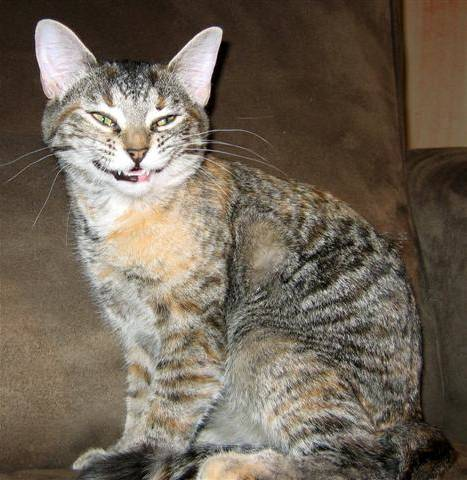

In [7]:
PIL.Image.open(str(cats[0]))

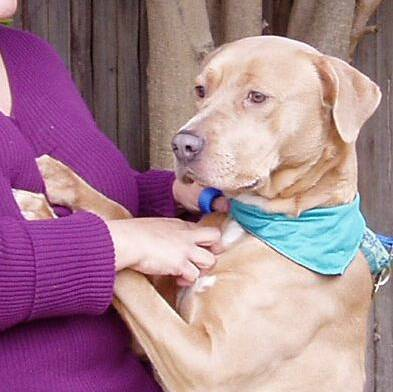

In [8]:
PIL.Image.open(str(dogs[0]))

In [9]:
batch_size = 32
img_height = 200
img_width = 200

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, 
    validation_split=0.2,
    subset='training', 
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

Found 8005 files belonging to 2 classes.
Using 6404 files for training.
Found 8005 files belonging to 2 classes.
Using 1601 files for validation.


In [11]:
class_names = train_ds.class_names
class_names

['cats', 'dogs']

2023-05-29 22:28:40.757514: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


<Figure size 1000x1000 with 0 Axes>

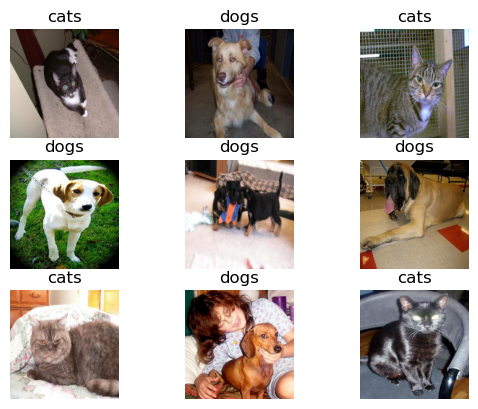

In [12]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    fig, ax = plt.subplots(3, 3)
    for i, ax in enumerate(ax.flat):
        ax.imshow(images[i].numpy().astype('uint8'))
        ax.set_title(class_names[labels[i]])
        ax.axis('off')
plt.show()

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 200, 200, 3)
(32,)


In [14]:
# AUTOTUNE used to to automatically determine the buffer sizes for caching and prefetching ops.
# cache func, caches the images upon first time load, for faster retrieval during training.
# shuffle is used to introduce randomness and prefent bias, the value indiciates the buffer size
# prefetch func, prefetches elements from the dataset when training, prefetchig overlaps the works of data loading and training.


# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# data_augmentation = tf.keras.Sequential(
#     [
#         tf.keras.layers.RandomFlip('horizontal', input_shape=(img_width, img_width, 3)),
#         tf.keras.layers.RandomRotation(0.1),
#         tf.keras.layers.RandomZoom(0.1)
#     ]
# )

In [16]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#   for i in range(9):
#     augmented_images = data_augmentation(images)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))
#     plt.axis("off")

In [17]:
num_classes = len(class_names)

with tf.device('/GPU:0'):
    model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.1),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    # tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    # tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    # tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 200, 200, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 200, 200, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                      

In [19]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [20]:
current_working_dir = os.getcwd()
current_working_dir
Output = pathlib.Path(os.path.join(current_working_dir, 'Output'))
Output

PosixPath('/Users/diegosabajo/Documents/projects/MachineLearning/Cats&Dogs_image_classification/Output')

In [21]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold
        self.best_val_acc = 0.0
        
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs['val_accuracy']
        if val_acc >= self.threshold:
            self.model.stop_training = True
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.model.save_weights('best_model_weights.h5')

early_stopping_callback = MyThresholdCallback(threshold=0.95)

logdir = os.path.join(Output, 'logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
modelfname = datetime.datetime.now().strftime('%Y%m%d-%H%M%S') + '.h5'

model_folder = pathlib.Path(os.path.join(Output, 'model'))
mcp_save = tf.keras.callbacks.ModelCheckpoint(os.path.join(model_folder, modelfname),
                                             save_best_only=True, monitor='val_loss', mode='min')

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

print(logdir)


/Users/diegosabajo/Documents/projects/MachineLearning/Cats&Dogs_image_classification/Output/logs/20230529-222841


In [22]:
epochs = 300
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[tensorboard_callback, mcp_save, early_stopping_callback]
                   )

Epoch 1/300
201/201 [==============================] - 17s 80ms/step - loss: 0.6923 - accuracy: 0.5584 - val_loss: 0.4909 - val_accuracy: 0.8926
Epoch 2/300
201/201 [==============================] - 16s 78ms/step - loss: 0.6376 - accuracy: 0.6234 - val_loss: 0.4132 - val_accuracy: 0.8645
Epoch 3/300
201/201 [==============================] - 16s 78ms/step - loss: 0.6075 - accuracy: 0.6643 - val_loss: 0.3622 - val_accuracy: 0.8888
Epoch 4/300
201/201 [==============================] - 16s 78ms/step - loss: 0.5972 - accuracy: 0.6788 - val_loss: 0.3781 - val_accuracy: 0.8613
Epoch 5/300
201/201 [==============================] - 16s 78ms/step - loss: 0.5809 - accuracy: 0.6961 - val_loss: 0.3210 - val_accuracy: 0.8969
Epoch 6/300
201/201 [==============================] - 16s 78ms/step - loss: 0.5785 - accuracy: 0.6960 - val_loss: 0.4947 - val_accuracy: 0.7470
Epoch 7/300
201/201 [==============================] - 16s 79ms/step - loss: 0.5659 - accuracy: 0.7055 - val_loss: 0.3826 - val_ac

KeyboardInterrupt: 

In [ ]:
loaded_model = tf.keras.models.load_model(os.path.join(Output, 'model', modelfname))

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    shuffle=False,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 8005 files belonging to 2 classes.


In [ ]:
modelfname

In [ ]:
loaded_model.evaluate(test_ds)

251/251 [==============================] - 5s 20ms/step - loss: 0.7115 - accuracy: 0.5410


[0.711517333984375, 0.54103684425354]

1/1 [==============================] - 0s 14ms/step


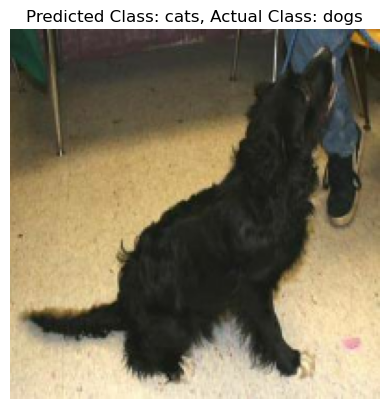

In [ ]:
class_labels = test_ds.class_names

random_index = random.randint(0, len(test_ds) - 1)
for i, (images, labels) in enumerate(test_ds):
    if i == random_index:
        image = images[0]
        actual_class = labels[0]
        break

# preprocessed_image = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(image)
# preprocessed_image = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")(preprocessed_image)
# preprocessed_image = tf.keras.layers.experimental.preprocessing.RandomRotation(0.3)(preprocessed_image)

# preprocessed_image = tf.expand_dims(preprocessed_image, axis=0)

prediction = loaded_model.predict(images)
prediction = tf.nn.softmax(prediction)
predicted_class = tf.argmax(prediction, axis=1)
predicted_class = predicted_class.numpy()[0]

plt.imshow(image.numpy().astype('uint8'))
plt.axis('off')
plt.title(f'Predicted Class: {class_labels[predicted_class]}, Actual Class: {class_labels[actual_class]}')
plt.show()


ValueError: x and y must have same first dimension, but have shapes (300,) and (1,)

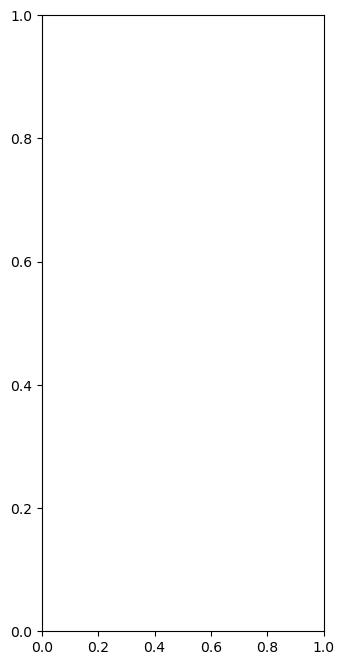

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1 )
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2 )
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()